<a href="https://colab.research.google.com/github/radxrad/radx-kg/blob/main/notebooks/visualization/AMIA-2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMIA 2024 Notebook
This notebook explores a subset of the radx Knowledge graph for the [AMIA 2024 Annual Symposium](https://amia.org/education-events/amia-2024-annual-symposium) paper.

This notebook runs queries on the radx-kg to explore the content and relationships among RADx-rad digital assets. Query results are displayed as tables, bar plots, choropleth maps, and visualized as subgraphs.

To run this notebook select ```Runtime -> Run all ``` from the menu.

The radx-kg consists of nodes and their relationships that can be queried with the [Cypher graph query language](https://neo4j.com/docs/getting-started/cypher-intro/#_getting_started_with_cypher).

<p align="center">
<img src="https://github.com/radxrad/radx-kg/blob/main/docs/Sub-schema.png?raw=1", width="100%">
</p>

## Setup
This notebook installs the Neo4j Graph Database and imports the RADx-KG data and metadata. The software setup may take 2 - 3 minutes.

In [1]:
#@title Check if Notebook is running in Google Colab
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    pass

In [2]:
#@title Install software
if in_colab:
    # enable third party widgets in Colab
    from google.colab import output
    output.enable_custom_widget_manager()
    output.no_vertical_scroll()

    # copy required files (temporary solution)
    !wget -q https://raw.githubusercontent.com/pwrose/neo4j-ipycytoscape/master/notebooks/neo4j_utils.py
    !wget -q https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/neo4j_bulk_importer.py
    !wget -q https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/utils.py
    !wget -q https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/PrepareNeo4jBulkImport.ipynb
    !wget -q https://raw.githubusercontent.com/radxrad/radx-kg/main/notebooks/visualization/embed.py

    !git clone --quiet https://github.com/radxrad/radx-kg.git

    # install software
    !apt -qq install openjdk-17-jre-headless 2>/dev/null > /dev/null
    %pip install -q papermill > /dev/null
    %pip install -q py2neo > /dev/null
    %pip install -q ipycytoscape > /dev/null
    %pip install -q python-dotenv > /dev/null
    %pip install -q plotly > /dev/null

    # set environment variables
    from dotenv import load_dotenv
    load_dotenv("/content/radx-kg/.env.colab")
else:
    # copy required files (temporary solution)
    !curl -s -O https://raw.githubusercontent.com/pwrose/neo4j-ipycytoscape/master/notebooks/neo4j_utils.py
    !curl -s -O https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/neo4j_bulk_importer.py
    !curl -s -O https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/utils.py
    !curl -s -O https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/PrepareNeo4jBulkImport.ipynb
    from dotenv import load_dotenv
    load_dotenv("../../.env", override=True)

<IPython.core.display.Javascript object>

In [3]:
#@title Imports
import os
import time
import pandas as pd
import seaborn as sns
import plotly.express as px
from py2neo import Graph
import neo4j_utils
import neo4j_bulk_importer

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Download and install Neo4j Graph Database
Install the Neo4j Community Edition.

In [4]:
neo4j_utils.download_neo4j_community()

### Import the RADx-rad Knowledge Graph
CSV data and metadata files are uploaded into the Neo4j Graph database from the [kg](https://github.com/radxrad/radx-kg/tree/main/kg) directory using the [kg-import](https://github.com/sbl-sdsc/kg-import) bulk upload scripts. For a description of the data organization and the specification of metadata [see](https://github.com/sbl-sdsc/kg-import/blob/main/README.md).

In [5]:
neo4j_bulk_importer.import_from_csv_to_neo4j_community();

Executing:   0%|          | 0/85 [00:00<?, ?cell/s]

Launching server........ running.


### Connect to the local Neo4j Graph database

In [6]:
database = os.environ.get("NEO4J_DATABASE")
username = os.environ.get("NEO4J_USERNAME")
password = os.environ.get("NEO4J_PASSWORD")
stylesheet = os.environ.get("NEO4J_STYLESHEET")

graph = Graph("bolt://localhost:7687", name=database, user=username, password=password)

## Table of Content
* [Metadata](#Metadata)
* [Subgraph](#Subgraph)
* [Publications](#Publications)
* [Presentations](#Presentations)
* [Events](#Events)
* [Organizations](#Organizations)
* [Funding Opportunities](#FundingOpportunities)
* [Grants](#Grants)
* [Fulltext Search](#FulltextSearch)
* [Semantic Search](#SemanticSearch)

## Metadata <a class="anchor" id="Metadata"></a>

### Node metadata
radx-kg is a self-describing KG. The MetaNodes and MetaRelationships define the structure of the KG and the properties of nodes and relationships. The query below lists the nodes in radx-kg and their properties.

In [7]:
query = """
MATCH (n:MetaNode) RETURN n;
"""
df = graph.run(query).to_data_frame()
metadata = df["n"].tolist()
metadata = pd.DataFrame(metadata)
metadata.fillna("", inplace=True)
metadata

,nodeName,country,geonames,ror,city,name,uei,duns,id,state,url,description,firstName,lastName,profileId,fullName,middleName,orcid,researchInitiative,narrative,subProject,fundingMechanism,awardCode,abstract,endDate,eventUrl,eventType,startDate,filingDate,inventors,applicants,grantedDate,status,journal,year,embedding,type,pmId,pmcId,doi,researchInitiativeUrl,websites,longName,videoUrl,presenters,presentationUrl
0,Organization,Country of the organization (string),Unique identifier for geolocation from https://www.geonames.org/ (string),Research Organization Registry id of the organization from https://ror.org/ (string),City of the organization (string),Name of the organization (string),US government-owned Unique Entity Identifier (UEI) for the organization (https://grants.nih.gov/grants/guide/notice-files/NOT-OD-21-170.html) (string),Data Universal Numbering System (DUNS) by Dun & Bradstreet (string),"Unique entity identifier: ror id if available, otherwise uei id (string)",State of the organization (string),Research Organization Registry landing page of the organization (string),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Software,,,,,Name of the software application or software repository (string),,,Identifier of the software application or software repository (string),,URL of the software application or software repository (string),Description of the software or software repository (string),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Researcher,,,,,Name of the researcher (lastname plus initials) (string),,,Unique researcher identifier (orcid preferred or NIH profile id) (string),,,,First name (string),Last name (string),Unique researcher identifier from NIH Reporter (https://api.reporter.nih.gov/) (string),First middle and last name (string),Middle name or middle initial (string),Unique reseacher identifier from ORICD (https://orcid.org) (string),,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,Grant,,,,,Title of the project (string),,,Unique identifier for the grant (Thesaurus:C16644) (string),,,,,,,,,,The initiative or program associated with this grant (string),Short description (string),A group of grants on related research areas (string),The type of award (Thesaurus:C20020) (string),Code of award (string),Project abstract (string),,,,,,,,,,,,,,,,,,,,,,
4,Event,Country of event location (string),,,City of event location (string),Name of the event (string),,,Unique identifier of the event (date and event number) (string),State or province of the event location (string),,,,,,,,,,,,,,,End data of event (date),URL of the event website (string),"Type of event: webinar, virtual conference, in-person conference, hybrid conference, virtual workshop, in-person workshop, hybrid workshop (string)",Start date of event (date),,,,,,,,,,,,,,,,,,
5,Dataset,,,,,Name of the dataset (string),,,Unique identifier for the dataset (string),,URL to dataset landing page (string),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,FundingOpportunity,,,,,Name of the funding opportunity (string),,,Unique identifier for the funding opportunity (Thesaurus:C20021) (string),,URL to funding opportunity description (string),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,Patent,,,,,Title of the patent (string),,,Identifier of the patents (string),,URL of patent webpage (string),,,,,,,,,,,,,,,,,,Date the patent application was filed (date),Name of the inventors (string[]),Name of the organization(s) that filed the patent application (string[]),Date the patent was granted (date),active or pending (string),,,,,,,,,,,,,
8,Publication,,,,,Title of the publication (string),,,Unique identifier for the publication (string),,URL of publication (string),,,,,,,,,,,,,Abstract of the publication (string),,,,,,,,,,Name of the journal (string),Year of publication (int),Embedding of title and abstract using SPECTER (https://github.com/allenai/specter) (float[]),primary or secondary citation (string),PubMed identifier of the publication (string),PubMedCentral identifier of the publication full text entry (string),Digital Object Ide

### Metagraph <a class="anchor" id="Metagraph"></a>
The metagraph shows the node labels and relationship types of the KG. Click on a node to display the node metadata.

In [8]:
query = """
MATCH p=(:MetaNode)-->(:MetaNode) RETURN p
"""
subgraph1 = graph.run(query).to_subgraph()

In [9]:
widget1 = neo4j_utils.draw_graph(subgraph1, stylesheet)
widget1.layout.height = "1024px"
widget1.set_layout(name="cola", padding=40, nodeSpacing=65, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget1
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view (Google Colab only)
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot. (Google Colab on Firefox only)
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 40, 'nodeSpacing': 65, 'nodeDimensionsIncludeLabe…

### Number of Nodes

In [10]:
query = """
MATCH (n) RETURN COUNT(n);
"""
print(f"Total number of nodes: {graph.evaluate(query)}")

Total number of nodes: 4690


### Number of nodes (digital assets) by node label (asset type)

In [11]:
query = """
MATCH (n) RETURN labels(n)[0] AS Node, COUNT(n) AS Count
ORDER BY Count DESC
"""
graph.run(query).to_data_frame()

,Node,Count
0,Researcher,2367
1,Publication,2012
2,Presentation,87
3,Organization,59
4,Dataset,50
5,Grant,48
6,Patent,17
7,FundingOpportunity,15
8,Event,14
9,MetaNode,11


### Number of relationships by relationship type

In [12]:
query = """
MATCH ()-[r]-() RETURN DISTINCT TYPE(r) AS Relationship, COUNT(r) AS Count
ORDER BY Count DESC
"""
graph.run(query).to_data_frame()

,Relationship,Count
0,AUTHORED,6946
1,CITES,4432
2,PRESENTED,348
3,IS_INVESTIGATOR_OF,228
4,USED,204
5,PRESENTED_AT,174
6,EMPLOYED_AT,166
7,CREATED,106
8,PROVIDES,98
9,SUPPORTED,94


## Subgraph for an investigator <a class="anchor" id="Subgraph"></a>
Get the digital assets for an investigator.

#### First neighbors in KG

In [13]:
researcher = "Cirrito"
query = """
MATCH p=(r:Researcher)--() WHERE r.lastName = $researcher RETURN p
"""
subgraph2 = graph.run(query, researcher=researcher).to_subgraph()

In [14]:
widget2 = neo4j_utils.draw_graph(subgraph2, stylesheet)
widget2.layout.height = "1024px"
widget2.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget2
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view (Google Colab only)
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot. (Google Colab on Firefox only)
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

#### First and second neighbors in KG

In [15]:
researcher = "Cirrito"
query = """
MATCH p=(r:Researcher)--()--() WHERE r.lastName = $researcher RETURN p
"""
subgraph3 = graph.run(query, researcher=researcher).to_subgraph()

In [16]:
widget3 = neo4j_utils.draw_graph(subgraph3, stylesheet)
widget3.layout.height = "1024px"
widget3.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget3
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view (Google Colab only)
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot. (Google Colab on Firefox only)
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Publications <a class="anchor" id="Publications"></a>

### Number of primary publications

In [17]:
query = """
MATCH (p:Publication) WHERE p.type = "primary" RETURN COUNT(p)
"""
print(f"Number of primary publications: {graph.evaluate(query)}")

Number of primary publications: 205


### Number of publication by RADx-rad subprojects

In [18]:
# create a color palette for projects
query = """
MATCH (g:Grant) RETURN DISTINCT g.subProject AS Project
"""
projects = graph.run(query).to_data_frame()["Project"].tolist()
colors = sns.color_palette()[:len(projects)]
palette = {project: color for project, color in zip(projects, colors)}

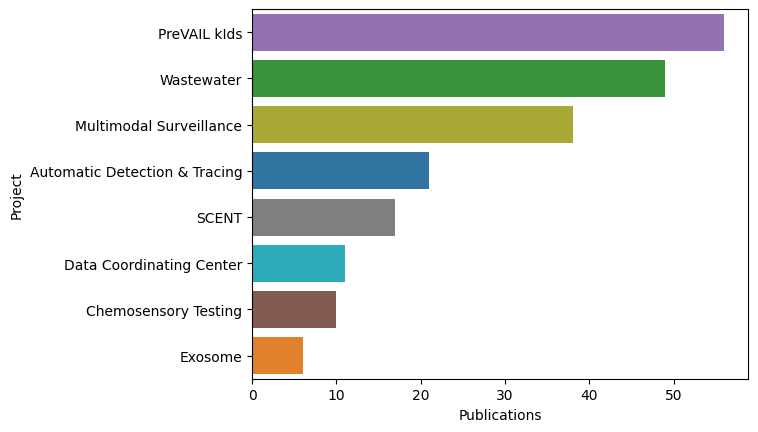

In [19]:
query = """
MATCH (p:Publication)<-[:AUTHORED]-(r:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Publications, g.subProject AS Project
ORDER BY Publications DESC
"""
publications = graph.run(query).to_data_frame()
sns.barplot(publications, x="Publications", y="Project", hue="Project", palette=palette);

### Number of secondary publications (citations)

In [20]:
query = """
MATCH (p:Publication) WHERE p.type = "secondary" RETURN COUNT(p)
"""
print(f"Number of citations: {graph.evaluate(query)}")

Number of citations: 1807


### Number of citations by subprojects

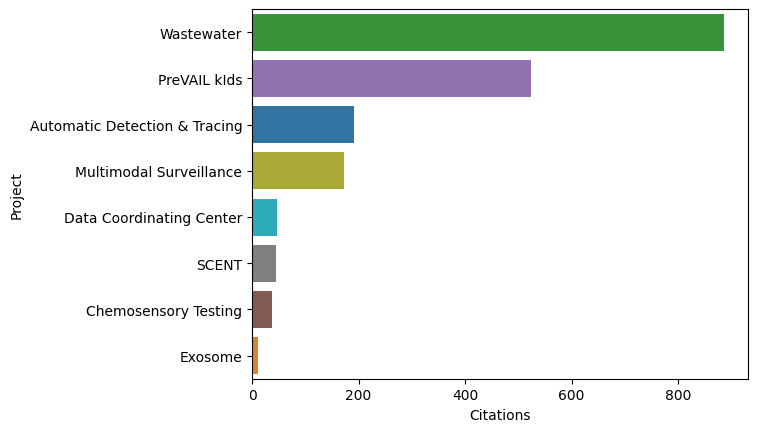

In [21]:
query = """
MATCH (p:Publication)-[CITES]->(:Publication)<-[:AUTHORED]-(:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Citations, g.subProject AS Project
ORDER BY Citations DESC
"""
citations = graph.run(query).to_data_frame()
sns.barplot(citations, x="Citations", y="Project", hue="Project", palette=palette);

### Publications authored by researcher from multiple RADx-rad grants

In [22]:
query = """
MATCH p=(g1:Grant)<-[:IS_INVESTIGATOR_OF]-(:Researcher)-[:AUTHORED]->(:Publication)<-[:AUTHORED]-(:Researcher)-[:IS_INVESTIGATOR_OF]-(g2:Grant) WHERE g1 <> g2 RETURN p
"""
subgraph4 = graph.run(query, researcher=researcher).to_subgraph()

In [23]:
widget4 = neo4j_utils.draw_graph(subgraph4, stylesheet)
widget4.layout.height = "1024px"
widget4.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget4
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view (Google Colab only)
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot. (Google Colab on Firefox only)
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Presentations <a class="anchor" id="Presentations"></a>
Presentations include poster presentations.

In [24]:
query = """
MATCH (p:Presentation) RETURN COUNT(p)
"""
print(f"Number of presentations: {graph.evaluate(query)}")

Number of presentations: 87


### Number of presentations by RADx-rad subprojects

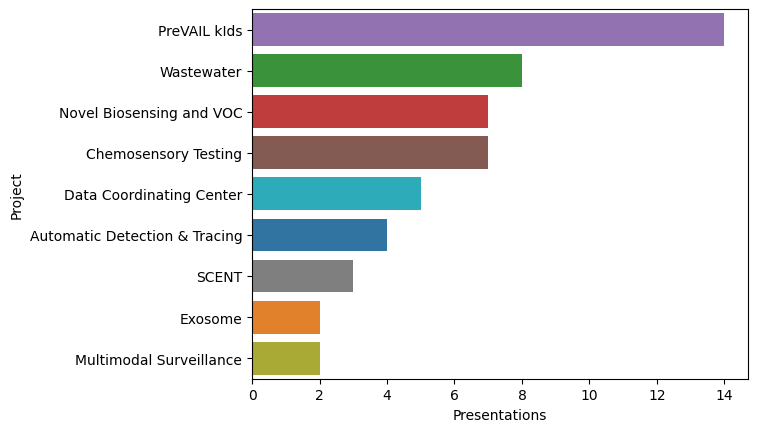

In [25]:
query = """
MATCH (p:Presentation)<-[:PRESENTED]-(:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Presentations, g.subProject AS Project
ORDER BY Presentations DESC
"""
presentations = graph.run(query).to_data_frame()
sns.barplot(presentations, x="Presentations", y="Project", hue="Project", palette=palette);

## Events <a class="anchor" id="Events"></a>

### Number of presentations per event

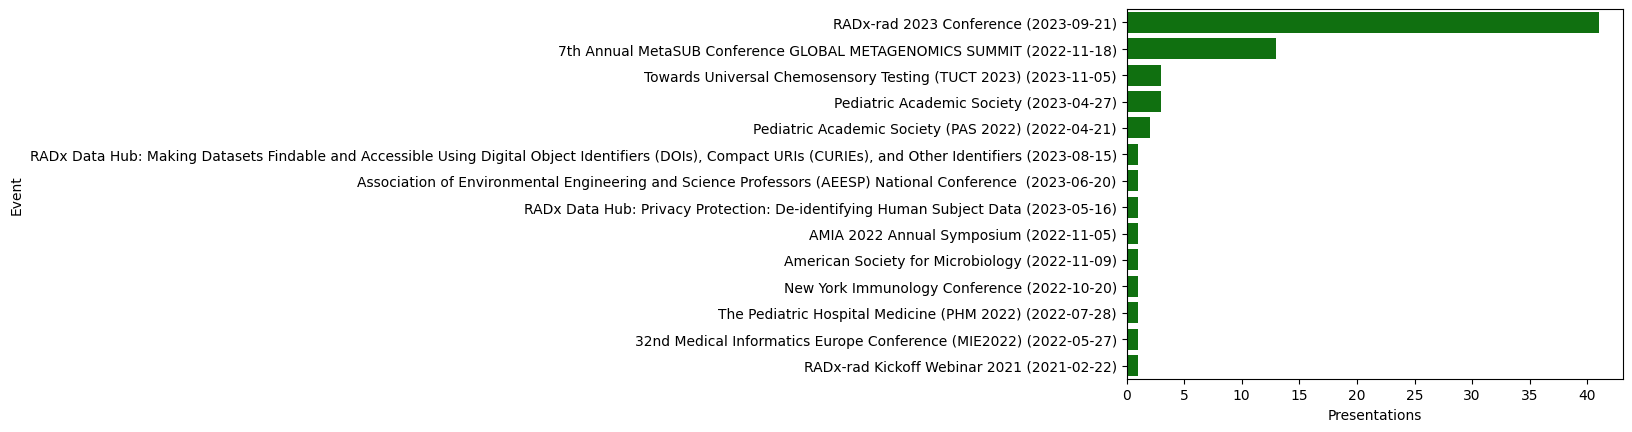

In [26]:
query = """
MATCH (e:Event)<-[:PRESENTED_AT]-(p:Presentation)<-[:PRESENTED]-(r:Researcher) RETURN e.name + " (" + e.startDate + ")" AS Event, COUNT(DISTINCT p) AS Presentations
ORDER BY Presentations DESC
"""
events = graph.run(query).to_data_frame()
sns.barplot(events, x="Presentations", y="Event", color="green");

### Table of Events

In [27]:
query = """
MATCH (e:Event) RETURN e.name AS Name, e.eventType AS Type, e.startDate AS Start_Date, e.endDate AS End_Date, e.city AS City, e.state AS State, e.country AS Country
ORDER BY Start_Date
"""
graph.run(query).to_data_frame()

,Name,Type,Start_Date,End_Date,City,State,Country
0,RADx-rad Kickoff Webinar 2021,webinar,2021-02-22,2021-02-22,None,None,None
1,Pediatric Academic Society (PAS 2022),in-person conference,2022-04-21,2022-04-25,Denver,CO,United States of America
2,32nd Medical Informatics Europe Conference (MIE2022),in-person conference,2022-05-27,2022-05-30,Nice,PAC,France
3,The Pediatric Hospital Medicine (PHM 2022),in-person conference,2022-07-28,2022-07-31,Buena Vista,FL,United States of America
4,New York Immunology Conference,in-person conference,2022-10-20,2022-10-20,Albany,NY,United States of America
5,AMIA 2022 Annual Symposium,in-person conference,2022-11-05,2022-11-09,Washington,DC,United States of America
6,American Society for Microbiology,in-person conference,2022-11-09,2022-11-12,Washington,DC,United States of America
7,7th Annual MetaSUB Conference GLOBAL METAGENOMICS SUMMIT,in-person conference,2022-11-18,2022-11-21,Miami Beach,FL,United States of America
8,Pediatric Academic Society,in-person conference,2023-04-27,2023-05-01,Washington,DC,United States of America
9,RADx Data Hub: Privacy Protection: De-identifying Human Subject Data,webinar,2023-05-16,2023-05-16,None,None,None


### Table of Presentations

In [28]:
query = """
MATCH (e:Event)<-[:PRESENTED_AT]-(p:Presentation) RETURN e.name AS Name, p.name AS Title, p.presenters AS Presenters
ORDER BY e.startDate
"""
graph.run(query).to_data_frame()

,Name,Title,Presenters
0,RADx-rad Kickoff Webinar 2021,An overview of FDA regulatory support available to RADx-rad awardees,Sara Brenner
1,RADx-rad Kickoff Webinar 2021,"A presentation by the principal investigators of the RADx-rad Data Coordination Center (DCC) explaining its data management plan, structure, and resources; as well as the responsibilities of RADx-rad awardees in working with the DCC",Lucila Ohno-Machado|Hua Xu|Eliah Aronoff-Spencer
2,RADx-rad Kickoff Webinar 2021,A presentation on the plan for data management and CDEs across the RADx Initiative,Susan Gregurick|Patti Brennan
3,RADx-rad Kickoff Webinar 2021,A description of how RADx-rad projects can leverage RADxTech infrastructure,Bruce Tromberg
4,RADx-rad Kickoff Webinar 2021,"A presentation on the overall goals, research interests, and organizational structure of the RADx-rad initiative",Judith Cooper|Patricia Powell
5,RADx-rad Kickoff Webinar 2021,"An introduction to the RADx Initiatives and its four programs: RADx-rad, -UP, and Tech/ATP; as well as an explanation of coordination amongst the programs",Francis Collins
6,RADx-rad Kickoff Webinar 2021,A welcome to the RADx-rad Initiative and explanation on how the presentation and subsequent Q&A session will flow,Tara Schwetz
7,Pediatric Academic Society (PAS 2022),Multisystem Inflammatory Syndrome in Children associated with COVID-19: A comparison study between cohorts from different geographic locations,C De-La-Cruz|AH Hogan|KW Herbst|DM Davalos|E Lopez-Medina|JC Salazar
8,Pediatric Academic Society (PAS 2022),Defining Clinical Phenotypes of COVID Viral Infections and Post-Viral Syndromes,CL Carroll|AH Hogan|KW Herbst|C Porcaro|N Schulman|H El-Chebib|JC Salazar
9,32nd Medical Informatics Europe Conference (MIE2022),Privacy and policy challenges in coordinating analyses of federated biomedical data across institutions,Xiaoqian Jiang|Tsung-Ting Kuo|Hua Xu|Lucila Ohno-Machado


## Organizations <a class="anchor" id="Organizations"></a>

### Grant PIs and their organizations

In [29]:
query = """
MATCH p=(o:Organization)<-[i:EMPLOYED_AT]-(r:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN p
"""
subgraph6 = graph.run(query).to_subgraph()

In [30]:
widget6 = neo4j_utils.draw_graph(subgraph6, stylesheet)
widget6.layout.height = "1024px"
widget6.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget6
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Funding Opportunities <a class="anchor" id="FundingOpportunities"></a>

In [31]:
query = """
MATCH p=(:FundingOpportunity)-[:PROVIDES]->(:Grant) RETURN p
"""
subgraph7 = graph.run(query).to_subgraph()

In [32]:
widget7 = neo4j_utils.draw_graph(subgraph7, stylesheet)
widget7.layout.height = "1024px"
widget7.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget7
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Grants <a class="anchor" id="Grants"></a>

### Type of Grants

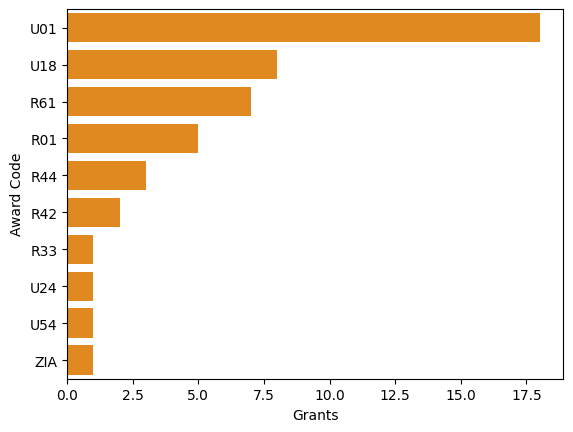

In [33]:
query = """
MATCH (g:Grant) RETURN g.awardCode AS `Award Code`, COUNT(DISTINCT g) AS Grants
ORDER BY Grants DESC, `Award Code`
"""
grants = graph.run(query).to_data_frame()
sns.barplot(grants, x="Grants", y="Award Code", color="darkorange");

### Number of grants per state
If a grant has PIs in multiple states, each site is counted as a grant location.

In [34]:
query = """
MATCH (g:Grant)<-[:IS_INVESTIGATOR_OF]-(:Researcher)-[:EMPLOYED_AT]->(o:Organization) RETURN COUNT(DISTINCT g) as grants, o.state AS locations
"""
df = graph.run(query).to_data_frame()
px.choropleth(df, locations="locations", color="grants", locationmode="USA-states", scope="usa", color_continuous_scale="Reds", labels={"grants": "Grants"})

## Fulltext Search <a class="anchor" id="Fulltext Search"></a>

### Full text query by keyword or phrase
A full text query returns all nodes that match the text query ([Query Syntax](https://lucene.apache.org/core/5_5_0/queryparser/org/apache/lucene/queryparser/classic/package-summary.html#Overview)). For exact matches, enclose the phrase in double quotes, e.g., ```'"aptamer"'```.

[Learn more about full-text searches.](https://graphaware.com/neo4j/2019/01/11/neo4j-full-text-search-deep-dive.html)

In [35]:
phrase = '"aptamer"'

In [36]:
query = """
CALL db.index.fulltext.queryNodes("fulltext", $phrase) YIELD node, score
RETURN node.id AS id, LABELS(node)[0] AS type, node.name AS title, score
ORDER BY type
"""
graph.run(query, phrase=phrase).to_data_frame()

,id,type,title,score
0,dbgap:phs002702.v1.p1,Dataset,A Scalable Aptamer-based Electrochemical Biosensor For Rapid Detection of SARS-CoV-2 From Saliva,1.626552
1,R44DE030852,Grant,Designer DNA Nanostructure Based Biosensing for Rapid COVID19 Detection and Monitoring using Saliva Sample,3.161678
2,R44DE030842,Grant,A scalable aptamer-based electrochemical biosensor for rapid detection of SARS-CoV-2 from saliva,2.951394
3,R61HD105590,Grant,Diagnosing and predicting risk in children with SARS-CoV-2- related illness,1.700071
4,U01AA029316,Grant,"Touchscreen-compatible, real-time electrochemical sensing of SARS-CoV-2",1.505746
5,U01HL152401,Grant,Washington Entrepreneurial Research Evaluation and Commercialization Hub,1.505746
6,U01AA029328,Grant,Development of an Automated Diagnostic Platform for SARS-CoV-2 Monitoring in Vulnerable Areas,1.464601
7,U01AA029348,Grant,Detection and Automatic Privacy-Protected Contact Tracing System Designed for COVID-19,1.126117
8,982f2b070830a8bb88ace0042d0100db,Presentation,A Novel Aptamer-based Lateral Flow Assay to Detect SARS-CoV-2,1.831485
9,f10c31d02026ef92e1edd49fbd367226,Presentation,A scalable aptamer-based electrochemical biosensor for rapid detection of SARS--Cov-2 from Saliva,1.626552


### Full text query using boolean operators
The full text query supports a variety of query types, including fuzzy, proximity, and range queries, as well as boolean operators ([Query Syntax](https://lucene.apache.org/core/5_5_0/queryparser/org/apache/lucene/queryparser/classic/package-summary.html#Overview)). The following example uses a query with an ```AND``` operator.

In [37]:
phrase = 'MIS-C AND biomarker'

In [38]:
query = """
CALL db.index.fulltext.queryNodes("fulltext", $phrase) YIELD node, score
RETURN node.id AS id, LABELS(node)[0] AS type, node.name AS title, score
ORDER BY type
"""
graph.run(query, phrase=phrase).to_data_frame()

,id,type,title,score
0,dbgap:phs002609.v1.p1,Dataset,Identifying Biomarker Signatures of Prognostic Value for Multisystem Inflammatory Syndrome in Children (MIS-C),4.470531
1,R61HD105613,Grant,Identifying biomarker signatures of prognostic value for Multisystem Inflammatory Syndrome in Children (MIS-C),9.815646
2,R61HD105591,Grant,A data science approach to identify and manage Multisystem Inflammatory Syndrome in Children (MIS-C) associated with SARS-CoV-2 infection and Kawasaki disease in pediatric patients,8.666932
3,R61HD105618,Grant,Discovery and clinical validation of host biomarkers of disease severity and multi-system inflammatory syndrome in children (MIS-C) with Covid-19,8.075189
4,c631a37fe6ff79589981f553a64eca2b,Presentation,Identifying biomarker signatures of prognostic value for Multisystem Inflammatory Syndrome in Children (MIS-C),4.470531
5,62fd74163cb87b922c288e64677db7fe,Presentation,Development of a biomarker signature using grating coupled fluorescence plasmonic microarray for diagnosis of MIS-C,4.149036
6,doi:10.3389/fbioe.2023.1066391,Publication,Development of a biomarker signature using grating-coupled fluorescence plasmonic microarray for diagnosis of MIS-C.,9.897055
7,doi:10.1136/ard-2022-223269,Publication,Deep immune profiling uncovers novel associations with clinical phenotypes of Multisystem Inflammatory Syndrome in Children (MIS-C),7.266278
8,doi:10.1101/2023.07.28.23293197,Publication,Plasma protein biomarkers distinguish Multisystem Inflammatory Syndrome in Children (MIS-C) from other pediatric infectious and inflammatory diseases,7.095535
9,doi:10.1177/15353702211046835,Publication,Osteopontin as a biomarker for COVID-19 severity and multisystem inflammatory syndrome in children: A pilot study,7.076604


### Shutdown Neo4j before closing this notebook.
If you run this notebook locally, uncomment the last line and run neo4j_utils.stop() to stop the database. Otherwise, the database server will keep running.

In [39]:
#neo4j_utils.stop()